# Imports

In [339]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import math

import datetime

from sklearn.impute import SimpleImputer


# Read Merged Data



In [340]:
url_merge_data = "https://raw.githubusercontent.com/fsmariam/HydroLogic/refs/heads/main/data/processed/Merged_Training_Set.csv"
df_train = pd.read_csv(url_merge_data)

In [341]:
df_train.head()


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


# Handling Missing Values

In [342]:
# Count missing values in each column (how many NaNs are in each column)
missing_values_count = df_train.isnull().sum().sort_values(ascending=False). head(10)
missing_values_count

scheme_name              28810
scheme_management         3878
installer                 3655
funder                    3637
public_meeting            3334
permit                    3056
subvillage                 371
wpt_name                     2
water_quality                0
extraction_type_class        0
dtype: int64

In [343]:
#### The percentage of missing values in our train data

# total number of cells in dataframe
total_cells = np.prod(df_train.shape) # np.prod is calculating the product of dimention of the Dataframe

# count missing cells
total_missing = df_train.isnull().sum().sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100

print(f"Total missing values: {total_missing}")
print(f"Percentage of missing data: {percent_missing:.2f}%")


Total missing values: 46743
Percentage of missing data: 1.92%


In [344]:
# Create a DataFrame showing total and percentage of missing values per column
missing_data = pd.DataFrame({
    'Total Missing': df_train.isnull().sum(),
    'Percent Missing': (df_train.isnull().sum() / len(df_train)) * 100
})

# Sort the DataFrame by 'Percent Missing' in descending order
missing_data_sorted = missing_data.sort_values(by='Percent Missing', ascending=False)

missing_data_sorted.head(10)

,Total Missing,Percent Missing
scheme_name,28810,48.501684
scheme_management,3878,6.528620
installer,3655,6.153199
funder,3637,6.122896
public_meeting,3334,5.612795
permit,3056,5.144781
subvillage,371,0.624579
wpt_name,2,0.003367
water_quality,0,0.000000
extraction_type_class,0,0.000000


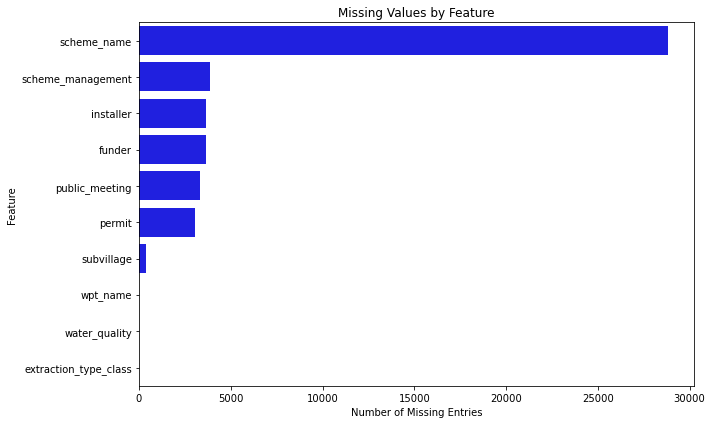

In [345]:
# Visualizing Missingness

plt.figure(figsize=(10, 6))
sns.barplot(x = missing_values_count.values, y=missing_values_count.index, color='blue')
plt.title('Missing Values by Feature')
plt.xlabel('Number of Missing Entries')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Counting Zero in each column

In [346]:
# Count how many times 0 appears in each column
zero_counts = (df_train == 0).sum().sort_values(ascending=False)

# Display top 10 columns with the most zero values
print(zero_counts.head(10))

num_private          58643
amount_tsh           41639
population           21381
construction_year    20709
gps_height           20438
permit               17492
public_meeting        5055
longitude             1812
district_code           23
id                       1
dtype: int64


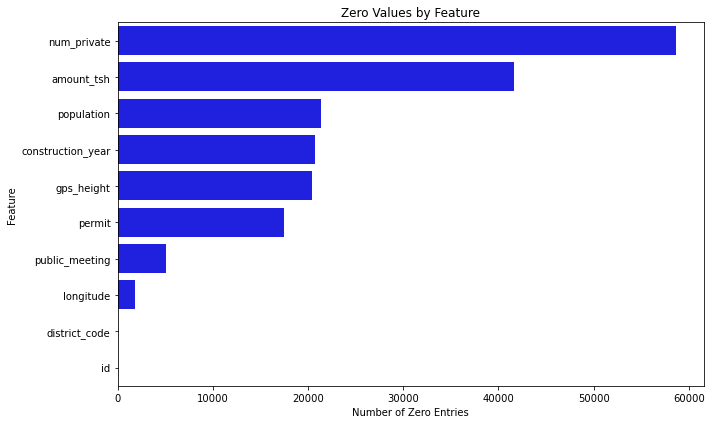

In [347]:
# Visualizing and Grouping 0

plt.figure(figsize=(10, 6))
sns.barplot(x = zero_counts.values[:10], y=zero_counts.index[:10], color='blue')
plt.title('Zero Values by Feature')
plt.xlabel('Number of Zero Entries')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Feature Summary

In [348]:
# Basic summary statics
def feature_summary(df):
    summary = pd.DataFrame({
        'Data Type': df.dtypes,
        'Missing Values': df.isnull().sum(),
        'Zero Values': (df == 0).sum(),
        'Unique Values': df.nunique()
    })
    # Add Percent of Missing Values
    summary['% Missing'] = (summary['Missing Values'] / len(df)) * 100
    
    # Classify Feature Type
    def classify_feature(col):
        if df[col].dtype == 'object':
            return 'Categorical'
        elif df[col].dtype in ['int64', 'float64']:
            if df[col].nunique() < 15:
                return 'Ordinal/Categorical'
            return 'Numerical'
        elif df[col].dtype == 'bool':
            return 'Boolean'
        elif 'date' in col:
            return 'Date'
        else:
            return 'Other'
    # Applies the classifier to each column.
    summary['Feature Type'] = summary.index.to_series().apply(classify_feature)
    return summary.sort_values(by='Missing Values', ascending=False)

# Run the summary
feature_summary(df_train)


,Data Type,Missing Values,Zero Values,Unique Values,% Missing,Feature Type
scheme_name,object,28810,0,2695,48.501684,Categorical
scheme_management,object,3878,0,11,6.528620,Categorical
installer,object,3655,0,2145,6.153199,Categorical
funder,object,3637,0,1896,6.122896,Categorical
public_meeting,object,3334,5055,2,5.612795,Categorical
permit,object,3056,17492,2,5.144781,Categorical
subvillage,object,371,0,19287,0.624579,Categorical
wpt_name,object,2,0,37399,0.003367,Categorical
water_quality,object,0,0,8,0.000000,Categorical
extraction_type_class,object,0,0,7,0.000000,Categorical


Tip: this is better to change the objects features with bool and datetime type of data to the bool and dattime64 as they use less memory than object.and that is better for the visualization and feature engineering. 

# Analyze patterns of missingness

### Tip: 
Key Types of Missing Data:
- MCAR (Missing Completely At Random): the missingness has no relationship with any other variable. no bias, we can drop or impute freely.

- MAR (Missing At Random): Missingness depends on other observed variables, but not the missing variable itself.Often safe to impute with group-based methods.

- MNAR (Missing Not At Random): The missingness depends on the value of the variable itself (or unobserved data). Groupings won’t fully explain this kind of missingness.

example: Is missingness correlated with other fields?
This helps answer if this data missing at random, or only in specific contexts?

## Missingness grouping funder with region

In [349]:
# how many missing values exist in the funder column, grouped by region
df_train['funder_missing'] = df_train['funder'].isnull()
funder_missing_by_region = df_train.groupby('region')['funder_missing'].mean().sort_values(ascending=False)
print(funder_missing_by_region)

region
Singida          0.462016
Mbeya            0.417331
Arusha           0.094328
Pwani            0.051992
Dar es Salaam    0.034783
Kagera           0.032268
Mwanza           0.013217
Tabora           0.007657
Mara             0.007110
Shinyanga        0.004617
Kigoma           0.003551
Mtwara           0.002312
Dodoma           0.002272
Rukwa            0.002212
Morogoro         0.001997
Manyara          0.001895
Iringa           0.001700
Lindi            0.001294
Kilimanjaro      0.001142
Ruvuma           0.000758
Tanga            0.000393
Name: funder_missing, dtype: float64


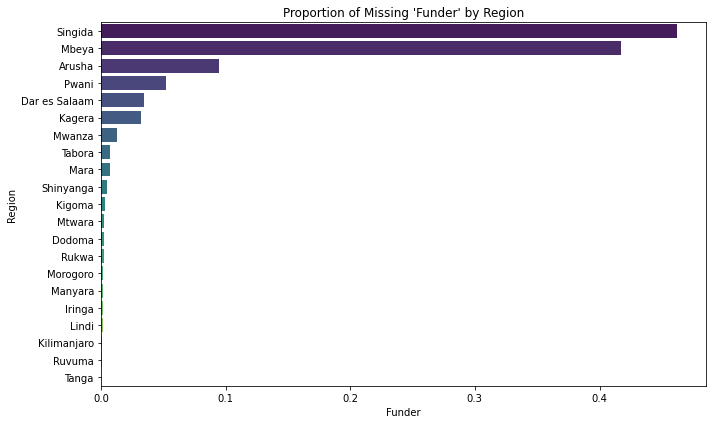

In [350]:
plt.figure(figsize=(10, 6))
sns.barplot(x=funder_missing_by_region.values, y=funder_missing_by_region.index, palette='viridis')
plt.title("Proportion of Missing 'Funder' by Region")
plt.xlabel("Funder")
plt.ylabel("Region")
plt.tight_layout()
plt.show()

Interpretation: The missingness in funder is clearly patterned by region (MAR).This suggests that the absence of funding data may be due to the Regional differences in reporting quality.

## Missingness grouping installer with funder

In [351]:
# how many missing values exist in the funder column, grouped by installer
df_train['funder_missing'] = df_train['funder'].isnull()
funder_missing_by_installer = df_train.groupby('installer')['funder_missing'].mean().sort_values(ascending=False)
print(funder_missing_by_installer)

installer
DHV Moro                   1.0
marafip                    1.0
ISSAC MOLLEL               1.0
ISSAC MOLLEl               1.0
rc ch                      1.0
                          ... 
Islamic community          0.0
Islamic Agency Tanzania    0.0
Islamic                    0.0
Islam                      0.0
world vision               0.0
Name: funder_missing, Length: 2145, dtype: float64


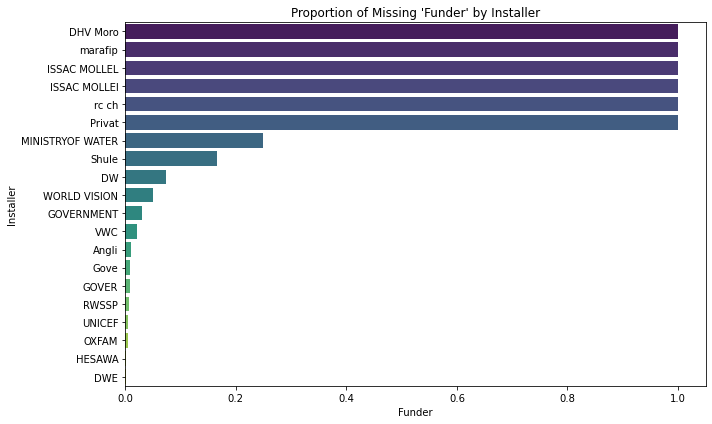

In [352]:
plt.figure(figsize=(10, 6))
sns.barplot(x=funder_missing_by_installer.values[:20], y=funder_missing_by_installer.index[:20], palette='viridis')
plt.title("Proportion of Missing 'Funder' by Installer")
plt.xlabel("Funder")
plt.ylabel("Installer")
plt.tight_layout()
plt.show()

Interpretation: Missingness in installer is strongly patterned by funder, it's not random (MAR).

## Missingness grouping scheme_name with region

In [353]:
# how many missing values exist in the scheme_name column, grouped by region
df_train['scheme_name_missing'] = df_train['scheme_name'].isnull()
scheme_name_missing_by_region = df_train.groupby('region')['scheme_name_missing'].mean().sort_values(ascending=False)
print(scheme_name_missing_by_region)

region
Shinyanga        0.905660
Dar es Salaam    0.860870
Mwanza           0.778852
Mara             0.764855
Tabora           0.757529
Rukwa            0.681969
Kagera           0.641737
Morogoro         0.602346
Mbeya            0.574693
Lindi            0.574386
Pwani            0.562049
Singida          0.539417
Mtwara           0.487861
Manyara          0.452937
Ruvuma           0.391667
Kigoma           0.359730
Tanga            0.277189
Dodoma           0.194911
Iringa           0.150548
Arusha           0.134627
Kilimanjaro      0.061658
Name: scheme_name_missing, dtype: float64


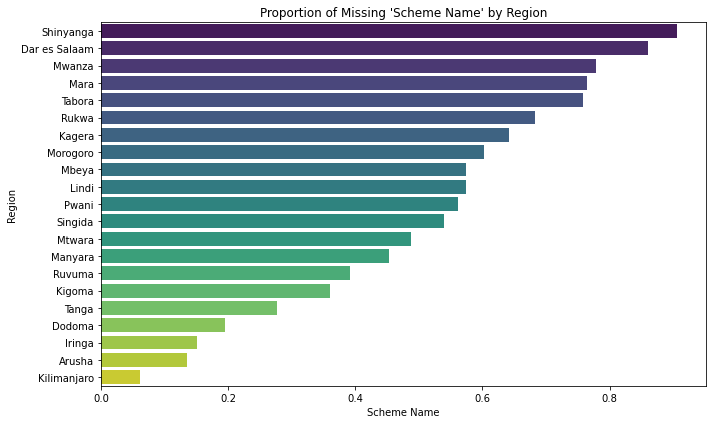

In [354]:
plt.figure(figsize=(10, 6))
sns.barplot(x=scheme_name_missing_by_region.values, y=scheme_name_missing_by_region.index, palette='viridis')
plt.title("Proportion of Missing 'Scheme Name' by Region")
plt.xlabel("Scheme Name")
plt.ylabel("Region")
plt.tight_layout()
plt.show()

Interpretation: Missingness in scheme_name is patterned, but it is also extremely widespread.
This may indicate:Field is not enforced or deemed important during data collection, or Low-quality or non-standardized field across regions

## Missingness grouping scheme_management with management

In [355]:
# how many missing values exist in the scheme_management column, grouped by management
df_train['scheme_management_missing'] = df_train['scheme_management'].isnull()
scheme_mgmt_missing_by_mgmt = df_train.groupby('management')['scheme_management_missing'].mean().sort_values(ascending=False)
print(scheme_mgmt_missing_by_mgmt)

management
unknown             0.834225
other               0.220379
wug                 0.097160
vwc                 0.060508
private operator    0.060375
trust               0.012821
parastatal          0.006222
wua                 0.002367
water authority     0.002212
company             0.001460
other - school      0.000000
water board         0.000000
Name: scheme_management_missing, dtype: float64


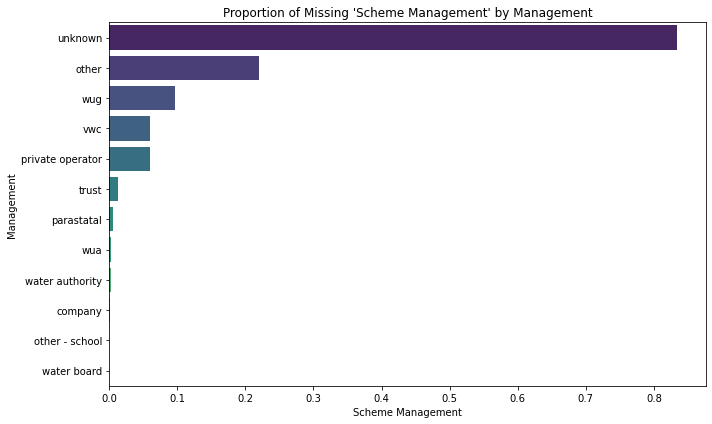

In [356]:
plt.figure(figsize=(10, 6))
sns.barplot(x=scheme_mgmt_missing_by_mgmt.values, y=scheme_mgmt_missing_by_mgmt.index, palette='viridis')
plt.title("Proportion of Missing 'Scheme Management' by Management")
plt.xlabel("Scheme Management")
plt.ylabel("Management")
plt.tight_layout()
plt.show()

interpretation: If management is "unknown" or "other", then scheme_management is very likely to be missing.and scheme_management may be a more structured subcategory of management.
Missingness in scheme_management is clearly patterned by management.It is not random, and reflects hierarchical or semantic dependency (MAR).

## Missingness grouping public_meeting with region

In [357]:
# how many missing values exist in the public_meeting column, grouped by region
df_train['public_meeting_missing'] = df_train['public_meeting'].isnull()
public_meeting_missing_by_region = df_train.groupby('region')['public_meeting_missing'].mean().sort_values(ascending=False)
print(public_meeting_missing_by_region)

region
Dar es Salaam    0.571429
Mara             0.390046
Ruvuma           0.197727
Shinyanga        0.129667
Lindi            0.117076
Mwanza           0.092843
Singida          0.059723
Rukwa            0.029314
Tabora           0.029096
Manyara          0.029059
Mtwara           0.018497
Arusha           0.011343
Kigoma           0.011009
Morogoro         0.007988
Mbeya            0.004742
Kilimanjaro      0.004567
Pwani            0.002657
Tanga            0.001178
Dodoma           0.000454
Iringa           0.000378
Kagera           0.000000
Name: public_meeting_missing, dtype: float64


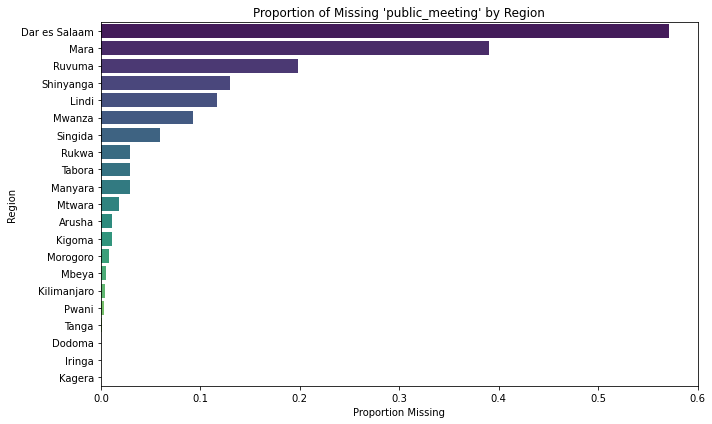

In [358]:
plt.figure(figsize=(10, 6))
sns.barplot(x=public_meeting_missing_by_region.values, y=public_meeting_missing_by_region.index, palette='viridis')
plt.title("Proportion of Missing 'public_meeting' by Region")
plt.xlabel("Proportion Missing")
plt.ylabel("Region")
plt.tight_layout()
plt.show()

Interpretation: A spike in certain regions means the missingness is patterned, not random! This variable may reflect deeper social, cultural, or administrative differences.

## Missingness grouping permit with region

In [359]:
# how many missing values exist in the permit column, grouped by region
df_train['permit_missing'] = df_train['permit'].isnull()
permit_missing_by_region = df_train.groupby('region')['permit_missing'].mean().sort_values(ascending=False)
print(permit_missing_by_region.head(10))

region
Singida          0.462016
Mbeya            0.238413
Mara             0.186389
Arusha           0.132836
Dar es Salaam    0.034783
Kilimanjaro      0.031514
Ruvuma           0.000758
Iringa           0.000567
Kagera           0.000000
Pwani            0.000000
Name: permit_missing, dtype: float64


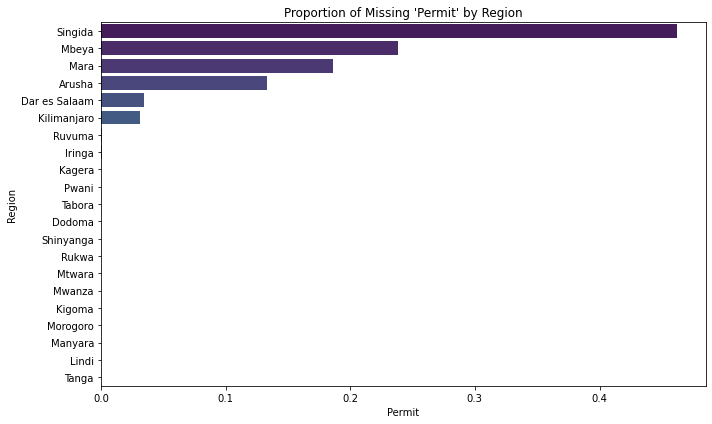

In [360]:
plt.figure(figsize=(10, 6))
sns.barplot(x=permit_missing_by_region.values, y=permit_missing_by_region.index, palette='viridis')
plt.title("Proportion of Missing 'Permit' by Region")
plt.xlabel("Permit")
plt.ylabel("Region")
plt.tight_layout()
plt.show()

interpretation: 
There's a strong regional pattern to missing permit values:
- Singida and Mbeya show high missingness (>20%–45%)
- Regions like Kagera and Pwani have complete records (0% missing)
Missingness in permit is not random. It varies systematically by region, possibly different legal/reporting systems

## Missingness grouping subvillage with region

In [361]:
# how many missing values exist in the subvillage column, grouped by region
df_train['subvillage_missing'] = df_train['subvillage'].isnull()
subvillage_missing_by_region = df_train.groupby('region')['subvillage_missing'].mean().sort_values(ascending=False)
print(subvillage_missing_by_region.head(10))

region
Dodoma       0.164016
Mwanza       0.003224
Arusha       0.000000
Morogoro     0.000000
Tabora       0.000000
Singida      0.000000
Shinyanga    0.000000
Ruvuma       0.000000
Rukwa        0.000000
Pwani        0.000000
Name: subvillage_missing, dtype: float64


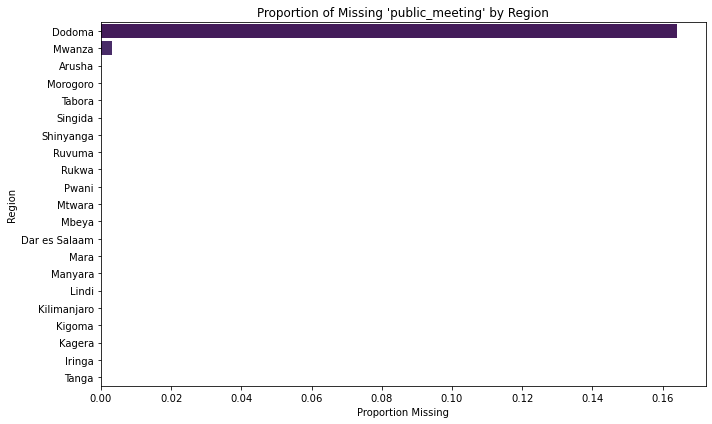

In [362]:
plt.figure(figsize=(10, 6))
sns.barplot(x=subvillage_missing_by_region.values, y=subvillage_missing_by_region.index, palette='viridis')
plt.title("Proportion of Missing 'public_meeting' by Region")
plt.xlabel("Proportion Missing")
plt.ylabel("Region")
plt.tight_layout()
plt.show()

Interpretation: 
- Dodoma stands out significantly with ~16% missing subvillage.
- All other regions are essentially complete.
- subvillage missingness is mildly patterned, but highly localized to Dodoma.

# Final Imputation Summary
- replaced with unknown: (funder, installer, scheme_name, scheme_management, and subvillage)
- replaced with most frequesnt value: (public meeting and permit, likely True)
- added binary missingless flags because these will help the model learn patterns in the missingness itself: (funder_missing, installer_missing, scheme_name_missing, 
scheme_management_missing, subvillage_missing, public_meeting_missing (all now False, but still useful if applied before filling), permit_missing (same as above))

# Convert Categorical Variables to Appropriate Formats

In [363]:
# view unique values
for col in df_train.columns:
    print(f"--- {col} ---")
    print(df_train[col].unique())
    print()

--- id ---
[69572  8776 34310 ... 37057 31282 26348]

--- amount_tsh ---
[6.00e+03 0.00e+00 2.50e+01 2.00e+01 2.00e+02 5.00e+02 5.00e+01 4.00e+03
 1.50e+03 6.00e+00 2.50e+02 1.00e+01 1.00e+03 1.00e+02 3.00e+01 2.00e+03
 4.00e+02 1.20e+03 4.00e+01 3.00e+02 2.50e+04 7.50e+02 5.00e+03 6.00e+02
 7.20e+03 2.40e+03 5.00e+00 3.60e+03 4.50e+02 4.00e+04 1.20e+04 3.00e+03
 7.00e+00 2.00e+04 2.80e+03 2.20e+03 7.00e+01 5.50e+03 1.00e+04 2.50e+03
 6.50e+03 5.50e+02 3.30e+01 8.00e+03 4.70e+03 7.00e+03 1.40e+04 1.30e+03
 1.00e+05 7.00e+02 1.00e+00 6.00e+01 3.50e+02 2.00e-01 3.50e+01 3.06e+02
 8.50e+03 1.17e+05 3.50e+03 5.20e+02 1.50e+01 6.30e+03 9.00e+03 1.50e+02
 1.20e+05 1.38e+05 3.50e+05 4.50e+03 1.30e+04 4.50e+04 2.00e+00 1.50e+04
 1.10e+04 5.00e+04 7.50e+03 1.63e+04 8.00e+02 1.60e+04 3.00e+04 5.30e+01
 5.40e+03 7.00e+04 2.50e+05 2.00e+05 2.60e+04 1.80e+04 2.60e+01 5.90e+02
 9.00e+02 9.00e+00 1.40e+03 1.70e+05 2.20e+02 3.80e+04 2.50e-01 1.20e+01
 6.00e+04 5.90e+01]

--- date_recorded ---
['2011-0

In [364]:
# just quick check what is inside the columns
print(df_train['public_meeting'].unique())
print(df_train['permit'].unique())

print(df_train['construction_year'].unique())
print(df_train['date_recorded'].unique())

# this is a categorical geographic region and has 9 unique values
print(df_train['basin'].unique())
# it may not be useful for modeling but as it has only 1 unique value i changed it to category
print(df_train['recorded_by'].unique())
# this column has 11 unique values making it ideal for categorical encoding later
print(df_train['scheme_management'].unique())



[True nan False]
[False True nan]
[1999 2010 2009 1986    0 2011 1987 1991 1978 1992 2008 1974 2000 2002
 2004 1972 2003 1980 2007 1973 1985 1970 1995 2006 1962 2005 1997 2012
 1996 1977 1983 1984 1990 1982 1976 1988 1989 1975 1960 1961 1998 1963
 1971 1994 1968 1993 2001 1979 1967 2013 1969 1981 1964 1966 1965]
['2011-03-14' '2013-03-06' '2013-02-25' '2013-01-28' '2011-07-13'
 '2011-03-13' '2012-10-01' '2012-10-09' '2012-11-03' '2011-08-03'
 '2011-02-20' '2013-02-18' '2012-10-14' '2013-03-15' '2012-10-20'
 '2011-08-04' '2011-07-04' '2011-09-04' '2011-07-22' '2011-02-22'
 '2011-02-27' '2013-02-10' '2011-10-04' '2013-11-03' '2013-01-21'
 '2013-01-16' '2011-07-11' '2013-03-05' '2013-03-16' '2011-03-23'
 '2011-03-16' '2013-03-19' '2011-03-11' '2011-02-23' '2013-03-28'
 '2011-07-16' '2011-03-27' '2013-02-11' '2013-10-03' '2011-03-12'
 '2011-07-07' '2013-01-15' '2013-03-18' '2012-10-22' '2013-02-05'
 '2011-07-27' '2011-04-04' '2013-02-21' '2011-08-18' '2011-07-31'
 '2011-08-01' '2011-07-14'

In [365]:
# Clean and Convert public_meeting
# Convert to string, clean casing and spaces, then map to booleans
df_train['public_meeting'] = df_train['public_meeting'].astype(str).str.strip().str.lower()
df_train['public_meeting'] = df_train['public_meeting'].map({'true': True, 'false': False})
df_train['public_meeting'] = df_train['public_meeting'].astype('boolean')

In [366]:
# Clean and Convert permit
df_train['permit'] = df_train['permit'].astype(str).str.strip().str.lower()
df_train['permit'] = df_train['permit'].map({'true': True, 'false': False})
df_train['permit'] = df_train['permit'].astype('boolean')

In [367]:
# Convert date_recorded to datetime
df_train['date_recorded'] = pd.to_datetime(df_train['date_recorded'], errors='coerce')

In [368]:
# Clean and Convert construction_year to datetime
# Remove years that are likely invalid (e.g., 0 or <1900)
df_train.loc[df_train['construction_year'] < 1900, 'construction_year'] = pd.NA

# Convert the year into a full datetime format (assumes Jan 1 of each year)
df_train['construction_year'] = pd.to_datetime(
    df_train['construction_year'], format='%Y', errors='coerce'
)


In [369]:
# Strip whitespace and lower the casing
df_train['basin'] = df_train['basin'].astype(str).str.strip().str.lower()
df_train['recorded_by'] = df_train['recorded_by'].astype(str).str.strip().str.lower()
df_train['scheme_management'] = df_train['scheme_management'].astype(str).str.strip().str.lower()

In [370]:
# covert to category
df_train['basin'] = df_train['basin'].astype('category')
df_train['recorded_by'] = df_train['recorded_by'].astype('category')
df_train['scheme_management'] = df_train['scheme_management'].astype('category')

# check data type

In [371]:
# Check Data Types
print(df_train[['public_meeting', 'permit', 'date_recorded', 'construction_year', 'basin', 'recorded_by', 'scheme_management']].dtypes)

public_meeting              boolean
permit                      boolean
date_recorded        datetime64[ns]
construction_year    datetime64[ns]
basin                      category
recorded_by                category
scheme_management          category
dtype: object


In [372]:
# Inspect Unique Values Again
print(df_train['public_meeting'].unique())
print(df_train['permit'].unique())
print(df_train['construction_year'].unique())
print(df_train['date_recorded'].unique())
print(df_train['basin'].unique())
print(df_train['recorded_by'].unique())
print(df_train['scheme_management'].unique())


<BooleanArray>
[True, <NA>, False]
Length: 3, dtype: boolean
<BooleanArray>
[False, True, <NA>]
Length: 3, dtype: boolean
['1999-01-01T00:00:00.000000000' '2010-01-01T00:00:00.000000000'
 '2009-01-01T00:00:00.000000000' '1986-01-01T00:00:00.000000000'
                           'NaT' '2011-01-01T00:00:00.000000000'
 '1987-01-01T00:00:00.000000000' '1991-01-01T00:00:00.000000000'
 '1978-01-01T00:00:00.000000000' '1992-01-01T00:00:00.000000000'
 '2008-01-01T00:00:00.000000000' '1974-01-01T00:00:00.000000000'
 '2000-01-01T00:00:00.000000000' '2002-01-01T00:00:00.000000000'
 '2004-01-01T00:00:00.000000000' '1972-01-01T00:00:00.000000000'
 '2003-01-01T00:00:00.000000000' '1980-01-01T00:00:00.000000000'
 '2007-01-01T00:00:00.000000000' '1973-01-01T00:00:00.000000000'
 '1985-01-01T00:00:00.000000000' '1970-01-01T00:00:00.000000000'
 '1995-01-01T00:00:00.000000000' '2006-01-01T00:00:00.000000000'
 '1962-01-01T00:00:00.000000000' '2005-01-01T00:00:00.000000000'
 '1997-01-01T00:00:00.000000000' 

In [373]:
# Check for Nulls
print("\nMissing values:")
print(df_train[['public_meeting', 'permit', 'date_recorded', 'construction_year', 'basin', 'recorded_by', 'scheme_management']].isnull().sum())


Missing values:
public_meeting        3334
permit                3056
date_recorded            0
construction_year    20709
basin                    0
recorded_by              0
scheme_management        0
dtype: int64


# Impute missing values

In [374]:
df_train_original = df_train.copy()

In [375]:
# Mode imputation for key categorical features
# Note: these are categorical features with relatively low missingness. by using mode (most frequent value) we keep the data realistic without introducing fake or synthetic categories. 
df_train['scheme_management'].fillna(df_train['scheme_management'].mode()[0], inplace=True)
df_train['public_meeting'].fillna(df_train['public_meeting'].mode()[0], inplace=True)
df_train['permit'].fillna(df_train['permit'].mode()[0], inplace=True)

# Fill high-missing field with 'Unknown'
# Note: filling with mode could mispresent the data, but unknow preserve the data as this data is not available. it also allows encoding later
df_train['scheme_name'].fillna('Unknown', inplace=True)

# Group rare funders and handle missing
# note: funder has high cardinality (many unique values), most funder occur very infrequently, we can replace the rare and missing values with other to make the modeling easier and more interpretable
top_funders = df_train['funder'].value_counts().nlargest(10).index
df_train['funder'] = df_train['funder'].apply(lambda x: x if pd.notnull(x) and x in top_funders else 'Other')

# the same for installer
top_installers = df_train['installer'].value_counts().nlargest(10).index
df_train['installer'] = df_train['installer'].apply(lambda x: x if pd.notnull(x) and x in top_installers else 'Other')

# group 5 top funder with region to preserve regional pattern because some funders are dominant in specific areas. 
df_train['funder'] = df_train.groupby('region')['funder'].transform(
    lambda x: x.where(x.isin(x.value_counts().nlargest(5).index), 'Other')
)

# these field has many few missing values, so mode is safe and minimally affects distribution
df_train['subvillage'].fillna(df_train['subvillage'].mode()[0], inplace=True)
df_train['wpt_name'].fillna(df_train['wpt_name'].mode()[0], inplace=True)

# Only use valid years to compute the median
#Note: construction_year is a numerical time-based feature. as it is already changed to datetime so it make sense to impute with valid date. median si more robost than mean because it is less affected by extreme outliers. 
valid_years = df_train['construction_year'].dropna()
median_year = valid_years.dt.year.median()

# Fill missing years with median, convert to datetime
df_train['construction_year'] = df_train['construction_year'].fillna(
    pd.to_datetime(str(int(median_year)), format='%Y')
)


Applying median for numerical features (robust to outliers), and most_frequent (mode) for categorical features

In [376]:
# Drop some column
columns_to_drop = ['num_private', 'id']
df_train.drop(columns = columns_to_drop, inplace = True)

In [377]:
# Recheck missing
print(df_train.isnull().sum().sort_values(ascending=False).head(10))


amount_tsh               0
extraction_type_group    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
dtype: int64


In [378]:
imputation_log = {
    'scheme_management': 'Mode imputation due to low missingness',
    'public_meeting': 'Boolean-type field, filled with mode',
    'permit': 'Boolean-type field, filled with mode',
    'scheme_name': 'High missingness, filled with "Unknown"',
    'funder': 'Grouped rare categories, filled missing with "Other"',
    'installer': 'Grouped rare categories, filled missing with "Other"',
    'subvillage': 'Low missingness, filled with mode',
    'wpt_name': 'Low missingness, filled with mode',
    'construction_year': 'Imputed with median year after converting to datetime. Missing values (including zeros and pre-1900 years) were treated as unknowns and filled with the median valid construction year.'
}
print (imputation_log)

{'scheme_management': 'Mode imputation due to low missingness', 'public_meeting': 'Boolean-type field, filled with mode', 'permit': 'Boolean-type field, filled with mode', 'scheme_name': 'High missingness, filled with "Unknown"', 'funder': 'Grouped rare categories, filled missing with "Other"', 'installer': 'Grouped rare categories, filled missing with "Other"', 'subvillage': 'Low missingness, filled with mode', 'wpt_name': 'Low missingness, filled with mode', 'construction_year': 'Imputed with median year after converting to datetime. Missing values (including zeros and pre-1900 years) were treated as unknowns and filled with the median valid construction year.'}


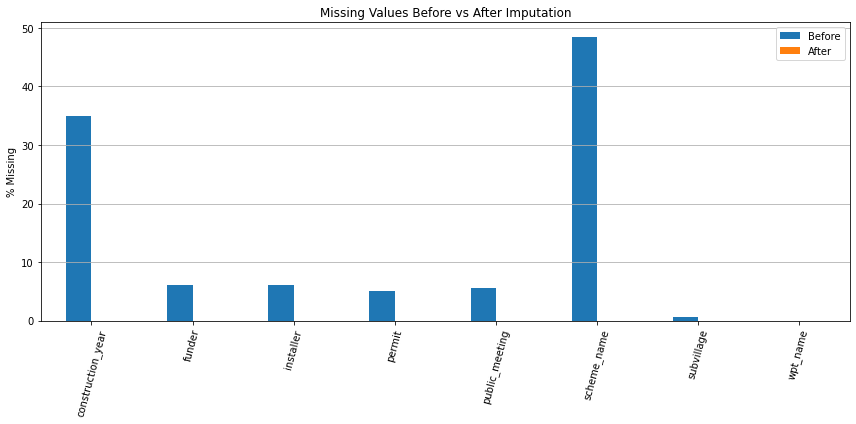

In [379]:
# Then compare missingness
missing_before = df_train_original.isnull().mean() * 100
missing_after = df_train.isnull().mean() * 100

# Create a comparison DataFrame
missing_compare = pd.DataFrame({'Before': missing_before, 'After': missing_after})
missing_compare = missing_compare[missing_compare['Before'] > 0]

# Plot comparison
missing_compare.plot(kind='bar', figsize=(12, 6), title='Missing Values Before vs After Imputation')
plt.ylabel('% Missing')
plt.xticks(rotation=75)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [380]:
# save the cleand dataframe in a file
df_train.to_csv("df_imputed.csv", index=False)
print ("File saved successfully!")

File saved successfully!
